In [1]:
import os
import cv2
import random
import shutil
import time
import matplotlib
import glob
import operator
import psutil
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from shutil import copyfile
import pandas as pd
import PIL
from mlxtend.plotting import plot_confusion_matrix

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
classify_train_dir = str(input("Classify Train Dir: "))
classify_train = os.path.join(classify_train_dir, 'classify train')
classify_train_lis = []
for file in os.listdir(classify_train):
    print(os.path.join(classify_train, file))
    classify_train_lis.append(os.path.join(classify_train, file))

TRAINING_DIR = classify_train_lis[0]
VALIDATION_DIR = classify_train_lis[1]
TESTING_DIR = classify_train_lis[2]

Classify Train Dir: /mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev
/mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/classify train/training
/mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/classify train/validation
/mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/classify train/testing


In [5]:
trainX = []
testX = []

trainY = []
testY = []

i,j = 0,0
for i in os.listdir(TRAINING_DIR):
    for j in os.listdir(os.path.join(TRAINING_DIR, i)):
        img = os.path.join(os.path.join(TRAINING_DIR, i), j)
        x = cv2.imread(img)
        trainX.append(x)

i,j = 0,0
for i in os.listdir(VALIDATION_DIR):
    for j in os.listdir(os.path.join(VALIDATION_DIR, i)):
        img = os.path.join(os.path.join(VALIDATION_DIR, i), j)
        x = cv2.imread(img)
        testX.append(x)
        
i,j = 0,0
for i in range(1064):
    trainY.append(0)
for j in range(1064):
    trainY.append(1)
for k in range(1064):
    trainY.append(2)
    
i,j = 0,0
for i in range(133):
    testY.append(0)
for j in range(133):
    testY.append(1)
for k in range(133):
    testY.append(2)

In [6]:
trainX = np.array(trainX)
testX = np.array(testX)

trainY = np.array(trainY)
testY = np.array(testY)

In [7]:
trainX.shape

(3192, 128, 128, 3)

In [8]:
trainY.shape

(3192,)

In [9]:
testX.shape

(399, 128, 128, 3)

In [10]:
testY.shape

(399,)

In [11]:
trainX_norm = trainX.astype('float32')
testX_norm = testX.astype('float32')

trainX_norm = trainX_norm / 255.0
testX_norm = testX_norm / 255.0

In [12]:
trainX_norm.shape

(3192, 128, 128, 3)

In [13]:
testX_norm.shape

(399, 128, 128, 3)

In [14]:
from tensorflow.keras.utils import to_categorical
trainY = to_categorical(trainY)
testY = to_categorical(testY)

In [15]:
x = np.concatenate((trainX_norm, testX_norm), axis=0)
y = np.concatenate((trainY, testY), axis=0)

In [16]:
learning_rate = float(input("Enter the initial learning rate: "))
epoch = int(input("Enter the maximum number of epochs: "))
batch_size = int(input("Enter batch size: "))

Enter the initial learning rate: 0.0001
Enter the maximum number of epochs: 30
Enter batch size: 256


In [17]:
char_name = str(input("Enter name of the characteristics folder: "))

char = os.path.join(classify_train_dir, char_name)

if not os.path.exists(char):
    os.mkdir(char)
else:
    shutil.rmtree(char)
    os.mkdir(char)

Enter name of the characteristics folder: bs


In [18]:
def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / 10))
    
best_model_address = os.path.join(char, 'best_model.h5')

callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 0),
            keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 0.001, patience = 10, verbose=0, mode = 'min', restore_best_weights = True),
            keras.callbacks.ModelCheckpoint(best_model_address, monitor = 'loss', verbose=0, save_best_only=True, save_weights_only=False, mode = 'min' , period=1)]

In [19]:
early_stop = str(input("Early stop prevents overfitting and sometimes it may result better output response. Do you want to early stop the training?(Y/N) "))


if early_stop.upper() == 'Y':
    print("\nMontoring Losses will consume more time to train the model but will return a perfect model with minimum losses.")
    monitor = int(input("Press 1 to monitor Validation Accuracy\nPress 2 to monitor Validation Loss\nPress 3 to monitor Training Accuracy\nPress 4 to monitor Training Loss\n"))
    patience = int(input('Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: '))


    if monitor == 1:
        metric = 'val_accuracy'
        mode = 'max'
        print("\nMONITORING VALIDATION ACCURACY..........\n")

    elif monitor == 2:
        metric = 'val_loss'
        mode = 'min'
        print("\nMONITORING VALIDATION LOSS..........\n")

    elif monitor == 3:
        metric = 'accuracy'
        mode = 'max'
        print("\nMONITORING TRAINING ACCURACY..........\n")

    elif monitor == 4:
        metric = 'loss'
        mode = 'min'
        print("\nMONITORING TRAINING LOSS..........\n")

    callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
                keras.callbacks.EarlyStopping(monitor = metric, min_delta = 0.001, patience = patience, verbose=1, mode = mode, restore_best_weights = True),
                keras.callbacks.ModelCheckpoint(best_model_address, monitor = metric, verbose=1, save_best_only=True, save_weights_only=False, mode = mode , period=1)]

    print("\nTraining will stop if Validation Accuracy doesn't show any improvements for " + str(patience) + " epcohs\n")

elif early_stop.upper() == 'N':
    monitor = int(input("Press 1 to monitor Validation Accuracy\nPress 2 to monitor Validation Loss\nPress 3 to monitor Training Accuracy\nPress 4 to monitor Training Loss\n"))

    if monitor == 1:
        metric = 'val_accuracy'
        mode = 'max'
        print("\nMONITORING VALIDATION ACCURACY..........\n")

    elif monitor == 2:
        metric = 'val_loss'
        mode = 'min'
        print("\nMONITORING VALIDATION LOSS..........\n")

    elif monitor == 3:
        metric = 'accuracy'
        mode = 'max'
        print("\nMONITORING TRAINING ACCURACY..........\n")

    elif monitor == 4:
        metric = 'loss'
        mode = 'min'
        print("\nMONITORING TRAINING LOSS..........\n")


    callback = [tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
                tf.keras.callbacks.ModelCheckpoint(best_model_address, monitor = metric, verbose = 1, save_best_only = True, save_weights_only = False, mode = mode, period = 1)]


Early stop prevents overfitting and sometimes it may result better output response. Do you want to early stop the training?(Y/N) n
Press 1 to monitor Validation Accuracy
Press 2 to monitor Validation Loss
Press 3 to monitor Training Accuracy
Press 4 to monitor Training Loss
4

MONITORING TRAINING LOSS..........



In [20]:
def create_model():
    print("\nTRAINING ON A COMPLEX CUSTOM MODEL:-")

    model = keras.models.Sequential()
    for l in range(layer):
        l += 1
        m = (2**l)//2
        for c in range(conv_layer):
            model.add(Conv2D(conv*m, (conv_size, conv_size), padding = 'same', input_shape = dim, activation = activation))
        model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(dense, activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(output_layer, activation=output_activation))
    return model

In [21]:
def vgg16():
    print("\nTRAINING ON VGG16 MODEL:-")

    base_model = keras.applications.vgg16.VGG16(input_shape = dim, weights = 'imagenet', include_top = False)

    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(dense, activation=activation)(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)

    predictions = Dense(output_layer, activation = output_activation)(x)

    model = Model(inputs = base_model.input, outputs=predictions)

    if train_base_model.upper() == 'Y':
        for layer in base_model.layers:
            layer.trainable = True
    elif train_base_model.upper() == 'N':
        for layer in base_model.layers:
            layer.trainable = False

    return model

In [22]:
def vgg19():
    print("\nTRAINING ON VGG19 MODEL:-")

    base_model = keras.applications.vgg19.VGG19(input_shape = dim, weights = 'imagenet', include_top = False)

    x = base_model.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(dense, activation=activation)(x)
    x = Dropout(dropout)(x)
    x = BatchNormalization()(x)

    predictions = Dense(output_layer, activation = output_activation)(x)

    model = Model(inputs = base_model.input, outputs=predictions)

    if train_base_model.upper() == 'Y':
        for layer in base_model.layers:
            layer.trainable = True
    elif train_base_model.upper() == 'N':
        for layer in base_model.layers:
            layer.trainable = False

    return model

In [23]:
if len(os.listdir(TRAINING_DIR)) > 2:
    output_activation = 'softmax'
    losses = 'categorical_crossentropy'
    output_layer = len(os.listdir(TRAINING_DIR))
else:
    output_activation = 'sigmoid'
    losses = 'binary_crossentropy'
    output_layer = 1

In [24]:
optimizer = keras.optimizers.Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

In [25]:
dense = int(input("Enter the no. of neurons in dense layer: "))
activation = str(input("Enter the activation function: "))
dropout = float(input("Enter the dropout percentage: "))
dropout = dropout/100

layer = int(input("Enter number of layers you want to apply: "))
conv_layer = int(input("Enter number of convolution layers you want to apply: "))
conv = int(input("Enter the no. of filters in the 1st convolution layer: "))
conv_size = int(input("Enter the size of filters: "))
h = int(input("Image Dimension(H or W): "))
w = h
dim = [h,w,3]

Enter the no. of neurons in dense layer: 128
Enter the activation function: relu
Enter the dropout percentage: 50
Enter number of layers you want to apply: 5
Enter number of convolution layers you want to apply: 1
Enter the no. of filters in the 1st convolution layer: 16
Enter the size of filters: 3
Image Dimension(H or W): 128


In [26]:
train_base_model = 'Y'
model = create_model()
model.summary()


TRAINING ON A COMPLEX CUSTOM MODEL:-
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D) 

In [27]:
from sklearn.model_selection import KFold
train_scores, val_scores, histories = list(), list(), list()

kfold = KFold(10, shuffle=True, random_state=1)

fold_no = 1

for train, test in kfold.split(x, y):
    model = create_model()
    model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                               tf.keras.metrics.Precision(), 
                                                               tf.keras.metrics.Recall(), 
                                                               tf.keras.metrics.TruePositives(), 
                                                               tf.keras.metrics.TrueNegatives(), 
                                                               tf.keras.metrics.FalsePositives(),
                                                               tf.keras.metrics.FalseNegatives()])
    
    print('------------------------------------------------------------------------')
    print('Training for fold {}...'.format(fold_no))
    
    history = model.fit(x[train], y[train], epochs=epoch, batch_size=batch_size, validation_data=(x[test], y[test]), callbacks = callback, verbose=1)
    
    train_score = model.evaluate(x[train], y[train], verbose=0)
    val_score = model.evaluate(x[test], y[test], verbose=0)
    
    print("\nTraining Acc: {}, Validation Acc: {}".format(train_score[1],val_score[1]))
    
    train_scores.append(train_score)
    val_scores.append(val_score)
    histories.append(history)
    
    fold_no = fold_no + 1


TRAINING ON A COMPLEX CUSTOM MODEL:-
------------------------------------------------------------------------
Training for fold 1...

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.0818 - accuracy: 0.3999 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 6462.0000 - false_positives: 0.0000e+00 - false_negatives: 3231.0000
Epoch 00001: loss improved from inf to 1.08177, saving model to /mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/bs/best_model.h5
13/13 [==============================] - 2s 162ms/step - loss: 1.0818 - accuracy: 0.3999 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 6462.0000 - false_positives: 0.0000e+00 - false_negatives: 3231.0000 - val_loss: 1.0655 - val_accuracy: 0.6111 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_


Epoch 00010: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 10/30
12/13 [==========================>...] - ETA: 0s - loss: 0.2175 - accuracy: 0.9261 - precision: 0.9304 - recall: 0.9219 - true_positives: 2832.0000 - true_negatives: 5932.0000 - false_positives: 212.0000 - false_negatives: 240.0000
Epoch 00010: loss improved from 0.24659 to 0.21541, saving model to /mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/bs/best_model.h5
13/13 [==============================] - 1s 71ms/step - loss: 0.2154 - accuracy: 0.9260 - precision: 0.9309 - recall: 0.9220 - true_positives: 2979.0000 - true_negatives: 6241.0000 - false_positives: 221.0000 - false_negatives: 252.0000 - val_loss: 0.2101 - val_accuracy: 0.9222 - val_precision: 0.9350 - val_recall: 0.9194 - val_true_positives: 331.0000 - val_true_negatives: 697.0000 - val_false_positives: 23.0000 - val_false_negatives: 29.0000

Epoch 00011: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 11

12/13 [==========================>...] - ETA: 0s - loss: 0.1742 - accuracy: 0.9476 - precision: 0.9518 - recall: 0.9440 - true_positives: 2900.0000 - true_negatives: 5997.0000 - false_positives: 147.0000 - false_negatives: 172.0000
Epoch 00019: loss improved from 0.18533 to 0.17509, saving model to /mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/bs/best_model.h5
13/13 [==============================] - 1s 88ms/step - loss: 0.1751 - accuracy: 0.9471 - precision: 0.9510 - recall: 0.9434 - true_positives: 3048.0000 - true_negatives: 6305.0000 - false_positives: 157.0000 - false_negatives: 183.0000 - val_loss: 0.1804 - val_accuracy: 0.9472 - val_precision: 0.9524 - val_recall: 0.9444 - val_true_positives: 340.0000 - val_true_negatives: 703.0000 - val_false_positives: 17.0000 - val_false_negatives: 20.0000

Epoch 00020: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 20/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1823 - accuracy: 0.


Epoch 00029: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 29/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1778 - accuracy: 0.9414 - precision: 0.9453 - recall: 0.9388 - true_positives: 2884.0000 - true_negatives: 5977.0000 - false_positives: 167.0000 - false_negatives: 188.0000
Epoch 00029: loss did not improve from 0.17349
13/13 [==============================] - 1s 67ms/step - loss: 0.1749 - accuracy: 0.9431 - precision: 0.9467 - recall: 0.9406 - true_positives: 3039.0000 - true_negatives: 6291.0000 - false_positives: 171.0000 - false_negatives: 192.0000 - val_loss: 0.1761 - val_accuracy: 0.9472 - val_precision: 0.9524 - val_recall: 0.9444 - val_true_positives: 340.0000 - val_true_negatives: 703.0000 - val_false_positives: 17.0000 - val_false_negatives: 20.0000

Epoch 00030: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 30/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1792 - accuracy: 0


Epoch 00009: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 9/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1606 - accuracy: 0.9518 - precision_1: 0.9552 - recall_1: 0.9499 - true_positives_1: 2918.0000 - true_negatives_1: 6007.0000 - false_positives_1: 137.0000 - false_negatives_1: 154.0000
Epoch 00009: loss improved from 0.17349 to 0.15819, saving model to /mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/bs/best_model.h5
13/13 [==============================] - 1s 76ms/step - loss: 0.1582 - accuracy: 0.9530 - precision_1: 0.9564 - recall_1: 0.9508 - true_positives_1: 3073.0000 - true_negatives_1: 6324.0000 - false_positives_1: 140.0000 - false_negatives_1: 159.0000 - val_loss: 0.1077 - val_accuracy: 0.9554 - val_precision_1: 0.9581 - val_recall_1: 0.9554 - val_true_positives_1: 343.0000 - val_true_negatives_1: 703.0000 - val_false_positives_1: 15.0000 - val_false_negatives_1: 16.0000

Epoch 00010: LearningRateScheduler reduci


Epoch 00018: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 18/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1256 - accuracy: 0.9619 - precision_1: 0.9653 - recall_1: 0.9603 - true_positives_1: 2950.0000 - true_negatives_1: 6038.0000 - false_positives_1: 106.0000 - false_negatives_1: 122.0000
Epoch 00018: loss improved from 0.12789 to 0.12670, saving model to /mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/bs/best_model.h5
13/13 [==============================] - 1s 75ms/step - loss: 0.1267 - accuracy: 0.9619 - precision_1: 0.9652 - recall_1: 0.9601 - true_positives_1: 3103.0000 - true_negatives_1: 6352.0000 - false_positives_1: 112.0000 - false_negatives_1: 129.0000 - val_loss: 0.0930 - val_accuracy: 0.9638 - val_precision_1: 0.9665 - val_recall_1: 0.9638 - val_true_positives_1: 346.0000 - val_true_negatives_1: 706.0000 - val_false_positives_1: 12.0000 - val_false_negatives_1: 13.0000

Epoch 00019: LearningRateScheduler reduci

12/13 [==========================>...] - ETA: 0s - loss: 0.1212 - accuracy: 0.9616 - precision_1: 0.9625 - recall_1: 0.9613 - true_positives_1: 2953.0000 - true_negatives_1: 6029.0000 - false_positives_1: 115.0000 - false_negatives_1: 119.0000
Epoch 00027: loss did not improve from 0.11985
13/13 [==============================] - 1s 67ms/step - loss: 0.1210 - accuracy: 0.9616 - precision_1: 0.9625 - recall_1: 0.9613 - true_positives_1: 3107.0000 - true_negatives_1: 6343.0000 - false_positives_1: 121.0000 - false_negatives_1: 125.0000 - val_loss: 0.0934 - val_accuracy: 0.9638 - val_precision_1: 0.9638 - val_recall_1: 0.9638 - val_true_positives_1: 346.0000 - val_true_negatives_1: 705.0000 - val_false_positives_1: 13.0000 - val_false_negatives_1: 13.0000

Epoch 00028: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 28/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1225 - accuracy: 0.9645 - precision_1: 0.9664 - recall_1: 0.9632 - true_positive


Epoch 00007: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 7/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1788 - accuracy: 0.9440 - precision_2: 0.9457 - recall_2: 0.9404 - true_positives_2: 2889.0000 - true_negatives_2: 5978.0000 - false_positives_2: 166.0000 - false_negatives_2: 183.0000
Epoch 00007: loss did not improve from 0.11985
13/13 [==============================] - 1s 67ms/step - loss: 0.1759 - accuracy: 0.9443 - precision_2: 0.9462 - recall_2: 0.9409 - true_positives_2: 3041.0000 - true_negatives_2: 6291.0000 - false_positives_2: 173.0000 - false_negatives_2: 191.0000 - val_loss: 0.1576 - val_accuracy: 0.9554 - val_precision_2: 0.9553 - val_recall_2: 0.9526 - val_true_positives_2: 342.0000 - val_true_negatives_2: 702.0000 - val_false_positives_2: 16.0000 - val_false_negatives_2: 17.0000

Epoch 00008: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 8/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1502 - accuracy:


Epoch 00017: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 17/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1131 - accuracy: 0.9642 - precision_2: 0.9654 - recall_2: 0.9629 - true_positives_2: 2958.0000 - true_negatives_2: 6038.0000 - false_positives_2: 106.0000 - false_negatives_2: 114.0000
Epoch 00017: loss did not improve from 0.11380
13/13 [==============================] - 1s 67ms/step - loss: 0.1167 - accuracy: 0.9629 - precision_2: 0.9640 - recall_2: 0.9616 - true_positives_2: 3108.0000 - true_negatives_2: 6348.0000 - false_positives_2: 116.0000 - false_negatives_2: 124.0000 - val_loss: 0.1233 - val_accuracy: 0.9554 - val_precision_2: 0.9554 - val_recall_2: 0.9554 - val_true_positives_2: 343.0000 - val_true_negatives_2: 702.0000 - val_false_positives_2: 16.0000 - val_false_negatives_2: 16.0000

Epoch 00018: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 18/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1145 - accuracy:


Epoch 00026: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 26/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1123 - accuracy: 0.9642 - precision_2: 0.9651 - recall_2: 0.9619 - true_positives_2: 2955.0000 - true_negatives_2: 6037.0000 - false_positives_2: 107.0000 - false_negatives_2: 117.0000
Epoch 00026: loss did not improve from 0.11032
13/13 [==============================] - 1s 67ms/step - loss: 0.1119 - accuracy: 0.9632 - precision_2: 0.9643 - recall_2: 0.9607 - true_positives_2: 3105.0000 - true_negatives_2: 6349.0000 - false_positives_2: 115.0000 - false_negatives_2: 127.0000 - val_loss: 0.1225 - val_accuracy: 0.9554 - val_precision_2: 0.9554 - val_recall_2: 0.9554 - val_true_positives_2: 343.0000 - val_true_negatives_2: 702.0000 - val_false_positives_2: 16.0000 - val_false_negatives_2: 16.0000

Epoch 00027: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 27/30
12/13 [==========================>...] - 

12/13 [==========================>...] - ETA: 0s - loss: 0.1707 - accuracy: 0.9408 - precision_3: 0.9446 - recall_3: 0.9375 - true_positives_3: 2880.0000 - true_negatives_3: 5975.0000 - false_positives_3: 169.0000 - false_negatives_3: 192.0000
Epoch 00005: loss did not improve from 0.10882
13/13 [==============================] - 1s 67ms/step - loss: 0.1699 - accuracy: 0.9412 - precision_3: 0.9448 - recall_3: 0.9381 - true_positives_3: 3032.0000 - true_negatives_3: 6287.0000 - false_positives_3: 177.0000 - false_negatives_3: 200.0000 - val_loss: 0.1593 - val_accuracy: 0.9554 - val_precision_3: 0.9551 - val_recall_3: 0.9471 - val_true_positives_3: 340.0000 - val_true_negatives_3: 702.0000 - val_false_positives_3: 16.0000 - val_false_negatives_3: 19.0000

Epoch 00006: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 6/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1565 - accuracy: 0.9495 - precision_3: 0.9526 - recall_3: 0.9479 - true_positives_3: 2912.0000 - 

13/13 [==============================] - 1s 114ms/step - loss: 0.0912 - accuracy: 0.9725 - precision_3: 0.9727 - recall_3: 0.9712 - true_positives_3: 3139.0000 - true_negatives_3: 6376.0000 - false_positives_3: 88.0000 - false_negatives_3: 93.0000 - val_loss: 0.0850 - val_accuracy: 0.9638 - val_precision_3: 0.9637 - val_recall_3: 0.9610 - val_true_positives_3: 345.0000 - val_true_negatives_3: 705.0000 - val_false_positives_3: 13.0000 - val_false_negatives_3: 14.0000

Epoch 00015: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 15/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0919 - accuracy: 0.9701 - precision_3: 0.9713 - recall_3: 0.9688 - true_positives_3: 2976.0000 - true_negatives_3: 6056.0000 - false_positives_3: 88.0000 - false_negatives_3: 96.0000
Epoch 00015: loss improved from 0.09116 to 0.09073, saving model to /mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/bs/best_model.h5
13/13 [==============================] - 1s 1


Epoch 00024: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 24/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0814 - accuracy: 0.9733 - precision_3: 0.9739 - recall_3: 0.9727 - true_positives_3: 2988.0000 - true_negatives_3: 6064.0000 - false_positives_3: 80.0000 - false_negatives_3: 84.0000
Epoch 00024: loss improved from 0.08758 to 0.08491, saving model to /mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/bs/best_model.h5
13/13 [==============================] - 1s 80ms/step - loss: 0.0849 - accuracy: 0.9731 - precision_3: 0.9737 - recall_3: 0.9725 - true_positives_3: 3143.0000 - true_negatives_3: 6379.0000 - false_positives_3: 85.0000 - false_negatives_3: 89.0000 - val_loss: 0.0805 - val_accuracy: 0.9638 - val_precision_3: 0.9665 - val_recall_3: 0.9638 - val_true_positives_3: 346.0000 - val_true_negatives_3: 706.0000 - val_false_positives_3: 12.0000 - val_false_negatives_3: 13.0000

Epoch 00025: LearningRateSch

12/13 [==========================>...] - ETA: 0s - loss: 0.4226 - accuracy: 0.8343 - precision_4: 0.8482 - recall_4: 0.8115 - true_positives_4: 2493.0000 - true_negatives_4: 5698.0000 - false_positives_4: 446.0000 - false_negatives_4: 579.0000
Epoch 00003: loss did not improve from 0.08285
13/13 [==============================] - 1s 70ms/step - loss: 0.4191 - accuracy: 0.8357 - precision_4: 0.8498 - recall_4: 0.8137 - true_positives_4: 2630.0000 - true_negatives_4: 5999.0000 - false_positives_4: 465.0000 - false_negatives_4: 602.0000 - val_loss: 0.3067 - val_accuracy: 0.9025 - val_precision_4: 0.9034 - val_recall_4: 0.8858 - val_true_positives_4: 318.0000 - val_true_negatives_4: 684.0000 - val_false_positives_4: 34.0000 - val_false_negatives_4: 41.0000

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 4/30
12/13 [==========================>...] - ETA: 0s - loss: 0.2891 - accuracy: 0.8939 - precision_4: 0.9052 - recall_4: 0.8828 - true_positives_4: 2712.0000 - 


Epoch 00013: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 13/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0984 - accuracy: 0.9707 - precision_4: 0.9719 - recall_4: 0.9697 - true_positives_4: 2979.0000 - true_negatives_4: 6058.0000 - false_positives_4: 86.0000 - false_negatives_4: 93.0000
Epoch 00013: loss did not improve from 0.08285
13/13 [==============================] - 1s 69ms/step - loss: 0.0987 - accuracy: 0.9694 - precision_4: 0.9708 - recall_4: 0.9681 - true_positives_4: 3129.0000 - true_negatives_4: 6370.0000 - false_positives_4: 94.0000 - false_negatives_4: 103.0000 - val_loss: 0.1420 - val_accuracy: 0.9526 - val_precision_4: 0.9526 - val_recall_4: 0.9526 - val_true_positives_4: 342.0000 - val_true_negatives_4: 701.0000 - val_false_positives_4: 17.0000 - val_false_negatives_4: 17.0000

Epoch 00014: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 14/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0926 - accuracy: 0.


Epoch 00023: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 23/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0940 - accuracy: 0.9701 - precision_4: 0.9710 - recall_4: 0.9688 - true_positives_4: 2976.0000 - true_negatives_4: 6055.0000 - false_positives_4: 89.0000 - false_negatives_4: 96.0000
Epoch 00023: loss did not improve from 0.08285
13/13 [==============================] - 1s 67ms/step - loss: 0.0915 - accuracy: 0.9709 - precision_4: 0.9721 - recall_4: 0.9697 - true_positives_4: 3134.0000 - true_negatives_4: 6374.0000 - false_positives_4: 90.0000 - false_negatives_4: 98.0000 - val_loss: 0.1403 - val_accuracy: 0.9499 - val_precision_4: 0.9497 - val_recall_4: 0.9471 - val_true_positives_4: 340.0000 - val_true_negatives_4: 700.0000 - val_false_positives_4: 18.0000 - val_false_negatives_4: 19.0000

Epoch 00024: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 24/30
12/13 [==========================>...] - ETA:

12/13 [==========================>...] - ETA: 0s - loss: 0.5886 - accuracy: 0.7507 - precision_5: 0.7982 - recall_5: 0.6566 - true_positives_5: 2017.0000 - true_negatives_5: 5634.0000 - false_positives_5: 510.0000 - false_negatives_5: 1055.0000
Epoch 00002: loss did not improve from 0.08285
13/13 [==============================] - 1s 66ms/step - loss: 0.5777 - accuracy: 0.7562 - precision_5: 0.8031 - recall_5: 0.6652 - true_positives_5: 2150.0000 - true_negatives_5: 5937.0000 - false_positives_5: 527.0000 - false_negatives_5: 1082.0000 - val_loss: 0.3487 - val_accuracy: 0.9025 - val_precision_5: 0.9143 - val_recall_5: 0.8914 - val_true_positives_5: 320.0000 - val_true_negatives_5: 688.0000 - val_false_positives_5: 30.0000 - val_false_negatives_5: 39.0000

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 3/30
12/13 [==========================>...] - ETA: 0s - loss: 0.3755 - accuracy: 0.8587 - precision_5: 0.8692 - recall_5: 0.8418 - true_positives_5: 2586.0000 


Epoch 00012: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 12/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1012 - accuracy: 0.9642 - precision_5: 0.9660 - recall_5: 0.9632 - true_positives_5: 2959.0000 - true_negatives_5: 6040.0000 - false_positives_5: 104.0000 - false_negatives_5: 113.0000
Epoch 00012: loss did not improve from 0.08285
13/13 [==============================] - 1s 67ms/step - loss: 0.1016 - accuracy: 0.9650 - precision_5: 0.9668 - recall_5: 0.9641 - true_positives_5: 3116.0000 - true_negatives_5: 6357.0000 - false_positives_5: 107.0000 - false_negatives_5: 116.0000 - val_loss: 0.0922 - val_accuracy: 0.9694 - val_precision_5: 0.9721 - val_recall_5: 0.9694 - val_true_positives_5: 348.0000 - val_true_negatives_5: 708.0000 - val_false_positives_5: 10.0000 - val_false_negatives_5: 11.0000

Epoch 00013: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 13/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1019 - accuracy:


Epoch 00022: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 22/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0888 - accuracy: 0.9704 - precision_5: 0.9723 - recall_5: 0.9697 - true_positives_5: 2979.0000 - true_negatives_5: 6059.0000 - false_positives_5: 85.0000 - false_negatives_5: 93.0000
Epoch 00022: loss did not improve from 0.08285
13/13 [==============================] - 1s 67ms/step - loss: 0.0891 - accuracy: 0.9700 - precision_5: 0.9718 - recall_5: 0.9694 - true_positives_5: 3133.0000 - true_negatives_5: 6373.0000 - false_positives_5: 91.0000 - false_negatives_5: 99.0000 - val_loss: 0.0905 - val_accuracy: 0.9694 - val_precision_5: 0.9721 - val_recall_5: 0.9694 - val_true_positives_5: 348.0000 - val_true_negatives_5: 708.0000 - val_false_positives_5: 10.0000 - val_false_negatives_5: 11.0000

Epoch 00023: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 23/30
12/13 [==========================>...] - ETA:

12/13 [==========================>...] - ETA: 0s - loss: 1.0103 - accuracy: 0.5085 - precision_6: 0.8208 - recall_6: 0.0850 - true_positives_6: 261.0000 - true_negatives_6: 6087.0000 - false_positives_6: 57.0000 - false_negatives_6: 2811.0000    
Epoch 00001: loss did not improve from 0.08285
13/13 [==============================] - 1s 112ms/step - loss: 0.9952 - accuracy: 0.5210 - precision_6: 0.8371 - recall_6: 0.1033 - true_positives_6: 334.0000 - true_negatives_6: 6399.0000 - false_positives_6: 65.0000 - false_negatives_6: 2898.0000 - val_loss: 0.6273 - val_accuracy: 0.8524 - val_precision_6: 0.8879 - val_recall_6: 0.5515 - val_true_positives_6: 198.0000 - val_true_negatives_6: 693.0000 - val_false_positives_6: 25.0000 - val_false_negatives_6: 161.0000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 2/30
12/13 [==========================>...] - ETA: 0s - loss: 0.5742 - accuracy: 0.7559 - precision_6: 0.7856 - recall_6: 0.6882 - true_positives_6: 2114.000


Epoch 00011: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 11/30
13/13 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.9681 - precision_6: 0.9687 - recall_6: 0.9672 - true_positives_6: 3126.0000 - true_negatives_6: 6363.0000 - false_positives_6: 101.0000 - false_negatives_6: 106.0000
Epoch 00011: loss did not improve from 0.08285
13/13 [==============================] - 1s 68ms/step - loss: 0.0938 - accuracy: 0.9681 - precision_6: 0.9687 - recall_6: 0.9672 - true_positives_6: 3126.0000 - true_negatives_6: 6363.0000 - false_positives_6: 101.0000 - false_negatives_6: 106.0000 - val_loss: 0.1051 - val_accuracy: 0.9666 - val_precision_6: 0.9693 - val_recall_6: 0.9666 - val_true_positives_6: 347.0000 - val_true_negatives_6: 707.0000 - val_false_positives_6: 11.0000 - val_false_negatives_6: 12.0000

Epoch 00012: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 12/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0939 - accuracy:

12/13 [==========================>...] - ETA: 0s - loss: 0.0763 - accuracy: 0.9717 - precision_6: 0.9720 - recall_6: 0.9714 - true_positives_6: 2984.0000 - true_negatives_6: 6058.0000 - false_positives_6: 86.0000 - false_negatives_6: 88.0000
Epoch 00020: loss improved from 0.07891 to 0.07623, saving model to /mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/bs/best_model.h5
13/13 [==============================] - 1s 87ms/step - loss: 0.0762 - accuracy: 0.9722 - precision_6: 0.9724 - recall_6: 0.9718 - true_positives_6: 3141.0000 - true_negatives_6: 6375.0000 - false_positives_6: 89.0000 - false_negatives_6: 91.0000 - val_loss: 0.1053 - val_accuracy: 0.9666 - val_precision_6: 0.9666 - val_recall_6: 0.9666 - val_true_positives_6: 347.0000 - val_true_negatives_6: 706.0000 - val_false_positives_6: 12.0000 - val_false_negatives_6: 12.0000

Epoch 00021: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 21/30
12/13 [======================


Epoch 00030: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 30/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0761 - accuracy: 0.9759 - precision_6: 0.9759 - recall_6: 0.9749 - true_positives_6: 2995.0000 - true_negatives_6: 6070.0000 - false_positives_6: 74.0000 - false_negatives_6: 77.0000
Epoch 00030: loss did not improve from 0.07377
13/13 [==============================] - 1s 66ms/step - loss: 0.0751 - accuracy: 0.9762 - precision_6: 0.9765 - recall_6: 0.9752 - true_positives_6: 3152.0000 - true_negatives_6: 6388.0000 - false_positives_6: 76.0000 - false_negatives_6: 80.0000 - val_loss: 0.1036 - val_accuracy: 0.9721 - val_precision_6: 0.9721 - val_recall_6: 0.9721 - val_true_positives_6: 349.0000 - val_true_negatives_6: 708.0000 - val_false_positives_6: 10.0000 - val_false_negatives_6: 10.0000

Training Acc: 0.9771039485931396, Validation Acc: 0.9721448421478271

TRAINING ON A COMPLEX CUSTOM MODEL:-
-----------------------------------


Epoch 00010: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 10/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1153 - accuracy: 0.9603 - precision_7: 0.9615 - recall_7: 0.9596 - true_positives_7: 2948.0000 - true_negatives_7: 6026.0000 - false_positives_7: 118.0000 - false_negatives_7: 124.0000
Epoch 00010: loss did not improve from 0.07377
13/13 [==============================] - 1s 67ms/step - loss: 0.1139 - accuracy: 0.9607 - precision_7: 0.9618 - recall_7: 0.9595 - true_positives_7: 3101.0000 - true_negatives_7: 6341.0000 - false_positives_7: 123.0000 - false_negatives_7: 131.0000 - val_loss: 0.1232 - val_accuracy: 0.9582 - val_precision_7: 0.9609 - val_recall_7: 0.9582 - val_true_positives_7: 344.0000 - val_true_negatives_7: 704.0000 - val_false_positives_7: 14.0000 - val_false_negatives_7: 15.0000

Epoch 00011: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 11/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1212 - accuracy


Epoch 00020: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 20/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0889 - accuracy: 0.9704 - precision_7: 0.9732 - recall_7: 0.9697 - true_positives_7: 2979.0000 - true_negatives_7: 6062.0000 - false_positives_7: 82.0000 - false_negatives_7: 93.0000
Epoch 00020: loss did not improve from 0.07377
13/13 [==============================] - 1s 67ms/step - loss: 0.0880 - accuracy: 0.9703 - precision_7: 0.9730 - recall_7: 0.9697 - true_positives_7: 3134.0000 - true_negatives_7: 6377.0000 - false_positives_7: 87.0000 - false_negatives_7: 98.0000 - val_loss: 0.0943 - val_accuracy: 0.9638 - val_precision_7: 0.9638 - val_recall_7: 0.9638 - val_true_positives_7: 346.0000 - val_true_negatives_7: 705.0000 - val_false_positives_7: 13.0000 - val_false_negatives_7: 13.0000

Epoch 00021: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 21/30
12/13 [==========================>...] - ETA: 0s - loss: 0.093


Epoch 00030: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 30/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0854 - accuracy: 0.9746 - precision_7: 0.9752 - recall_7: 0.9727 - true_positives_7: 2988.0000 - true_negatives_7: 6068.0000 - false_positives_7: 76.0000 - false_negatives_7: 84.0000
Epoch 00030: loss did not improve from 0.07377
13/13 [==============================] - 1s 66ms/step - loss: 0.0862 - accuracy: 0.9743 - precision_7: 0.9749 - recall_7: 0.9725 - true_positives_7: 3143.0000 - true_negatives_7: 6383.0000 - false_positives_7: 81.0000 - false_negatives_7: 89.0000 - val_loss: 0.0950 - val_accuracy: 0.9582 - val_precision_7: 0.9582 - val_recall_7: 0.9582 - val_true_positives_7: 344.0000 - val_true_negatives_7: 703.0000 - val_false_positives_7: 15.0000 - val_false_negatives_7: 15.0000

Training Acc: 0.9740098714828491, Validation Acc: 0.9582172632217407

TRAINING ON A COMPLEX CUSTOM MODEL:-
-----------------------------------


Epoch 00010: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 10/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1015 - accuracy: 0.9648 - precision_8: 0.9658 - recall_8: 0.9645 - true_positives_8: 2963.0000 - true_negatives_8: 6039.0000 - false_positives_8: 105.0000 - false_negatives_8: 109.0000
Epoch 00010: loss did not improve from 0.07377
13/13 [==============================] - 1s 67ms/step - loss: 0.0993 - accuracy: 0.9650 - precision_8: 0.9659 - recall_8: 0.9647 - true_positives_8: 3118.0000 - true_negatives_8: 6354.0000 - false_positives_8: 110.0000 - false_negatives_8: 114.0000 - val_loss: 0.1316 - val_accuracy: 0.9554 - val_precision_8: 0.9581 - val_recall_8: 0.9554 - val_true_positives_8: 343.0000 - val_true_negatives_8: 703.0000 - val_false_positives_8: 15.0000 - val_false_negatives_8: 16.0000

Epoch 00011: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 11/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0893 - accuracy


Epoch 00020: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 20/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0747 - accuracy: 0.9736 - precision_8: 0.9742 - recall_8: 0.9727 - true_positives_8: 2988.0000 - true_negatives_8: 6065.0000 - false_positives_8: 79.0000 - false_negatives_8: 84.0000
Epoch 00020: loss did not improve from 0.07199
13/13 [==============================] - 1s 68ms/step - loss: 0.0728 - accuracy: 0.9746 - precision_8: 0.9752 - recall_8: 0.9737 - true_positives_8: 3147.0000 - true_negatives_8: 6384.0000 - false_positives_8: 80.0000 - false_negatives_8: 85.0000 - val_loss: 0.1139 - val_accuracy: 0.9638 - val_precision_8: 0.9638 - val_recall_8: 0.9638 - val_true_positives_8: 346.0000 - val_true_negatives_8: 705.0000 - val_false_positives_8: 13.0000 - val_false_negatives_8: 13.0000

Epoch 00021: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 21/30
12/13 [==========================>...] - ETA: 0s - loss: 0.075


Epoch 00030: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 30/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0734 - accuracy: 0.9766 - precision_8: 0.9769 - recall_8: 0.9766 - true_positives_8: 3000.0000 - true_negatives_8: 6073.0000 - false_positives_8: 71.0000 - false_negatives_8: 72.0000
Epoch 00030: loss did not improve from 0.07019
13/13 [==============================] - 1s 66ms/step - loss: 0.0719 - accuracy: 0.9771 - precision_8: 0.9774 - recall_8: 0.9771 - true_positives_8: 3158.0000 - true_negatives_8: 6391.0000 - false_positives_8: 73.0000 - false_negatives_8: 74.0000 - val_loss: 0.1114 - val_accuracy: 0.9638 - val_precision_8: 0.9638 - val_recall_8: 0.9638 - val_true_positives_8: 346.0000 - val_true_negatives_8: 705.0000 - val_false_positives_8: 13.0000 - val_false_negatives_8: 13.0000

Training Acc: 0.978960394859314, Validation Acc: 0.9637883305549622

TRAINING ON A COMPLEX CUSTOM MODEL:-
------------------------------------


Epoch 00010: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 10/30
12/13 [==========================>...] - ETA: 0s - loss: 0.1130 - accuracy: 0.9632 - precision_9: 0.9644 - recall_9: 0.9613 - true_positives_9: 2953.0000 - true_negatives_9: 6035.0000 - false_positives_9: 109.0000 - false_negatives_9: 119.0000
Epoch 00010: loss did not improve from 0.07019
13/13 [==============================] - 1s 67ms/step - loss: 0.1130 - accuracy: 0.9629 - precision_9: 0.9640 - recall_9: 0.9610 - true_positives_9: 3106.0000 - true_negatives_9: 6348.0000 - false_positives_9: 116.0000 - false_negatives_9: 126.0000 - val_loss: 0.0872 - val_accuracy: 0.9749 - val_precision_9: 0.9749 - val_recall_9: 0.9749 - val_true_positives_9: 350.0000 - val_true_negatives_9: 709.0000 - val_false_positives_9: 9.0000 - val_false_negatives_9: 9.0000

Epoch 00011: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 11/30
13/13 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 


Epoch 00020: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 20/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0825 - accuracy: 0.9746 - precision_9: 0.9746 - recall_9: 0.9740 - true_positives_9: 2992.0000 - true_negatives_9: 6066.0000 - false_positives_9: 78.0000 - false_negatives_9: 80.0000
Epoch 00020: loss did not improve from 0.07019
13/13 [==============================] - 1s 67ms/step - loss: 0.0817 - accuracy: 0.9749 - precision_9: 0.9749 - recall_9: 0.9743 - true_positives_9: 3149.0000 - true_negatives_9: 6383.0000 - false_positives_9: 81.0000 - false_negatives_9: 83.0000 - val_loss: 0.0767 - val_accuracy: 0.9805 - val_precision_9: 0.9832 - val_recall_9: 0.9805 - val_true_positives_9: 352.0000 - val_true_negatives_9: 712.0000 - val_false_positives_9: 6.0000 - val_false_negatives_9: 7.0000

Epoch 00021: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 21/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0791 


Epoch 00030: LearningRateScheduler reducing learning rate to 1.0000000000000002e-06.
Epoch 30/30
12/13 [==========================>...] - ETA: 0s - loss: 0.0754 - accuracy: 0.9727 - precision_9: 0.9736 - recall_9: 0.9717 - true_positives_9: 2985.0000 - true_negatives_9: 6063.0000 - false_positives_9: 81.0000 - false_negatives_9: 87.0000
Epoch 00030: loss did not improve from 0.07019
13/13 [==============================] - 1s 66ms/step - loss: 0.0782 - accuracy: 0.9731 - precision_9: 0.9740 - recall_9: 0.9722 - true_positives_9: 3142.0000 - true_negatives_9: 6380.0000 - false_positives_9: 84.0000 - false_negatives_9: 90.0000 - val_loss: 0.0766 - val_accuracy: 0.9805 - val_precision_9: 0.9804 - val_recall_9: 0.9777 - val_true_positives_9: 351.0000 - val_true_negatives_9: 711.0000 - val_false_positives_9: 7.0000 - val_false_negatives_9: 8.0000

Training Acc: 0.9767945408821106, Validation Acc: 0.9805014133453369


In [28]:
i = 0
val_acc = []
tr_acc = []

for i in range(len(val_scores)):
    val_acc.append(val_scores[i][1])
    tr_acc.append(train_scores[i][1])

In [29]:
cv_val = np.mean(val_acc), np.std(val_acc)
cv_val

(0.962688809633255, 0.00972186320125935)

In [30]:
cv_train = np.mean(tr_acc), np.std(tr_acc)
cv_train

(0.9713474929332733, 0.00768340739437874)

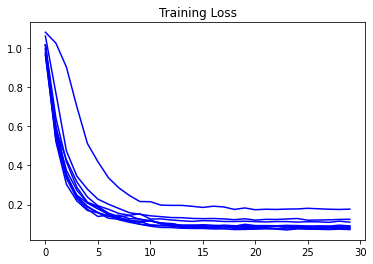

In [31]:
# plot loss
for i in range(len(histories)):
    plt.title('Training Loss')
    plt.plot(histories[i].history['loss'], color='blue')

plt.savefig(os.path.join(char, 'tr_loss.eps'))
plt.show()

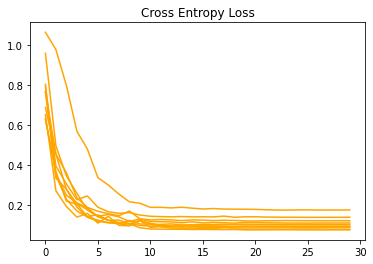

In [32]:
# plot loss
for i in range(len(histories)):
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['val_loss'], color='orange')
    
plt.savefig(os.path.join(char, 'val_loss.eps'))
plt.show()

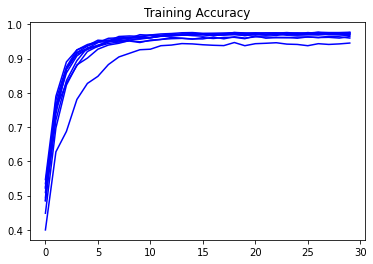

In [33]:
for i in range(len(histories)):
    plt.title('Training Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue')

plt.savefig(os.path.join(char, 'tr_acc.eps'))
plt.show()

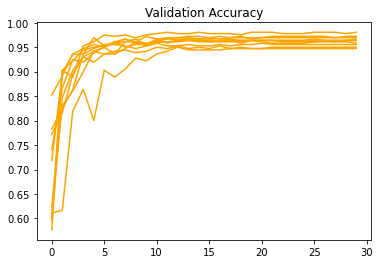

In [34]:
for i in range(len(histories)):
    plt.title('Validation Accuracy')
    plt.plot(histories[i].history['val_accuracy'], color='orange')

plt.savefig(os.path.join(char, 'val_acc.eps'))
plt.show()

In [35]:
tr_loss = []
tr_acc = []
tr_val_loss = []
tr_val_acc = []

In [36]:
i,j = 0,0
for i in range(len(histories[i].history['loss'])):
    tr_loss_epch = []
    tr_acc_epch = []
    tr_val_loss_epch = []
    tr_val_acc_epch = []
    for j in range(len(histories)):
        tr_loss_epch.append((histories[j].history['loss'][i]))
        tr_acc_epch.append((histories[j].history['accuracy'][i]))
        tr_val_loss_epch.append((histories[j].history['val_loss'][i]))
        tr_val_acc_epch.append((histories[j].history['val_accuracy'][i]))

    tr_loss.append(np.mean(tr_loss_epch))
    tr_acc.append(np.mean(tr_acc_epch))
    tr_val_loss.append(np.mean(tr_val_loss_epch))
    tr_val_acc.append(np.mean(tr_val_acc_epch))

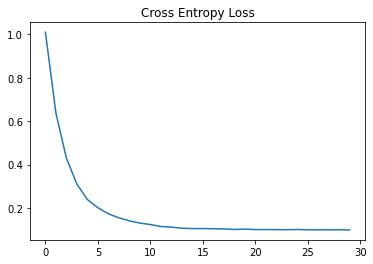

In [37]:
plt.plot(tr_loss)
plt.title('Cross Entropy Loss')
plt.savefig(os.path.join(char, 'avg_tr_loss.eps'))
plt.show()

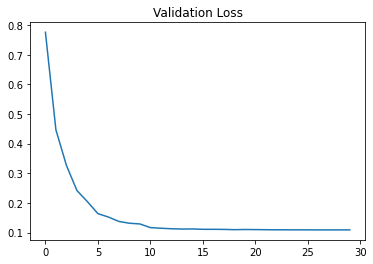

In [38]:
plt.plot(tr_val_loss)
plt.title('Validation Loss')
plt.savefig(os.path.join(char, 'avg_val_loss.eps'))
plt.show()

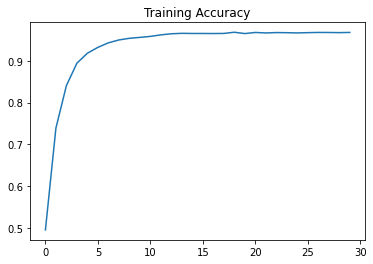

In [39]:
plt.plot(tr_acc)
plt.title('Training Accuracy')
plt.savefig(os.path.join(char, 'avg_tr_acc.eps'))
plt.show()

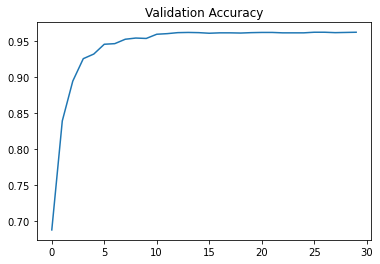

In [40]:
plt.plot(tr_val_acc)
plt.title('Validation Accuracy')
plt.savefig(os.path.join(char, 'avg_val_acc.eps'))
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


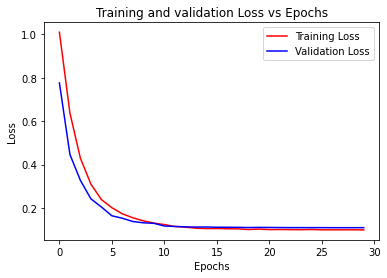

In [41]:
plt.plot(tr_loss, 'r', label='Training Loss')
plt.plot(tr_val_loss, 'b', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation Loss vs Epochs')
plt.legend()
accuracy_fig_name = "loss.eps"
plt.savefig(os.path.join(char, accuracy_fig_name))
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


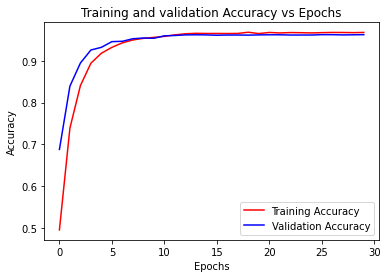

In [42]:
plt.plot(tr_acc, 'r', label='Training Accuracy')
plt.plot(tr_val_acc, 'b', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation Accuracy vs Epochs')
plt.legend()
accuracy_fig_name = "acc.eps"
plt.savefig(os.path.join(char, accuracy_fig_name))
plt.show()

In [43]:
avg_acc = [0.8177834570407867, 0.9376832842826843, 0.9507407367229461, 0.9590330839157104, 0.9644479572772979, 0.9672636210918426, 0.9708529055118561, 0.9742255330085754, 0.9756177484989166, 0.9787120282649994, 0.9833533644676209, 0.9845601081848144, 0.9853336691856385, 0.9857667922973633, 0.9863237679004669, 0.986076295375824, 0.9873449206352234, 0.987592351436615, 0.9881183445453644, 0.9877780437469482, 0.9886134386062622, 0.9882112443447113, 0.9879636585712432, 0.9893560409545898, 0.9886753916740417, 0.9886753380298614, 0.9890776157379151, 0.9887681901454926, 0.9884897887706756, 0.9893870711326599]

avg_loss = [0.441286239027977, 0.18764268159866332, 0.14736506789922715, 0.12502468451857568, 0.10924018770456315, 0.10032874718308449, 0.08865706324577331, 0.07955924049019814, 0.07447400689125061, 0.06553563885390759, 0.052590470761060715, 0.047181392461061476, 0.045953874662518504, 0.04360850192606449, 0.04368525892496109, 0.0432166539132595, 0.040728616341948506, 0.04065413549542427, 0.038710431382060054, 0.03790312483906746, 0.03666601553559303, 0.03731717672199011, 0.03630349412560463, 0.035444045625627044, 0.03603373393416405, 0.037305054068565366, 0.03509139027446508, 0.035768402740359306, 0.035683196038007736, 0.03449596855789423]

avg_val_acc = [0.9409718334674835, 0.9532195925712585, 0.9596255004405976, 0.9621301531791687, 0.9679789483547211, 0.96881383061409, 0.968534517288208, 0.9688153922557831, 0.9718763530254364, 0.9707644641399383, 0.9729913413524628, 0.9754982948303222, 0.9735492050647736, 0.9752197504043579, 0.9757768511772156, 0.9760554015636445, 0.9760546267032624, 0.9760561764240265, 0.9760561645030975, 0.976056170463562, 0.9760554134845734, 0.9766125202178955, 0.9760554075241089, 0.976612514257431, 0.976612514257431, 0.9760554015636445, 0.9763339579105377, 0.976612514257431, 0.976612514257431, 0.9763339579105377]

avg_val_loss = [0.1783444717526436, 0.13258887454867363, 0.1172481432557106, 0.10920769795775413, 0.1021569587290287, 0.09321553744375706, 0.0971818745136261, 0.08618548102676868, 0.08876880444586277, 0.08480228334665299, 0.07901486158370971, 0.07823383174836636, 0.07734064869582653, 0.07769119255244732, 0.07639574483036995, 0.07823078334331512, 0.07922342047095299, 0.07578882910311222, 0.07600142024457454, 0.07770153060555458, 0.07677891403436661, 0.07649801969528199, 0.07647013179957866, 0.07638908475637436, 0.07628891617059708, 0.07643482349812984, 0.07631793171167374, 0.07631488777697086, 0.07648159191012383, 0.07680309936404228]

epochs = []
i=0
for i in range(1, len(avg_loss)+1):
    epochs.append(i)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


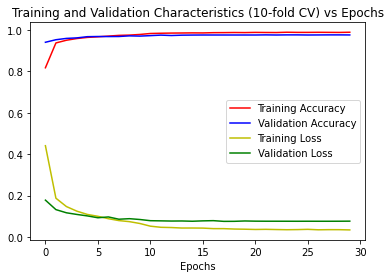

In [44]:
plt.plot(avg_acc, 'r', label='Training Accuracy')
plt.plot(avg_val_acc, 'b', label='Validation Accuracy')
plt.plot(avg_loss, 'y', label='Training Loss')
plt.plot(avg_val_loss, 'g', label='Validation Loss')

plt.legend()

plt.xlabel("Epochs")
plt.title('Training and Validation Characteristics (10-fold CV) vs Epochs')

plt.savefig(os.path.join(classify_train_dir, 'tot-acc-loss.eps'))
plt.show()

In [45]:
test_class_list = []
for test_name in os.listdir(TESTING_DIR):
    test = os.path.join(TESTING_DIR,test_name)
    test_class_list.append(test)
test_class_list.sort()

In [46]:
test_class_list

['/mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/classify train/testing/covid',
 '/mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/classify train/testing/normal',
 '/mnt/d4f6e37f-b51e-4cce-9bf9-bf48e0de6271/DATASETS/Health/COVID/3_class_rev/classify train/testing/pneumonia']

In [47]:
def max_pred(pred):
    pred_categorical = keras.utils.to_categorical(pred)
    if len(os.listdir(TRAINING_DIR)) > 2:
        pred_max = np.argmax(pred)
    else:
        pred_max = np.argmax(pred_categorical)
    return pred_max

In [48]:
y_true = testY
y_true = [np.where(r==1)[0][0] for r in y_true]
labels = {'covid': 0, 'normal': 1, 'pneumonia': 2}

In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 

model = tf.keras.models.load_model(os.path.join(char, 'best_model.h5'))

y_pred = []
for i in range(len(os.listdir(TRAINING_DIR))):
    for filename in os.listdir(test_class_list[i]):
        file = os.path.join(test_class_list[i], filename)
        img = image.load_img(file, target_size=(128,128))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)

        images = np.vstack([x])

        pred = model.predict(images, batch_size = batch_size)
        pred_max = max_pred(pred)
        
        y_pred.append(pred_max)

y_pred.sort()
print("Calculating CLASSIFICATION REPORT..........:")
classification_report = classification_report(y_true, y_pred, target_names=labels)
print(classification_report)

print("\nCalculating SENSITIVITY & SPECIFICITY..........:")
cm = confusion_matrix(y_true, y_pred)
total = sum(sum(cm))
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Sensitivity = {:.4f}".format(sensitivity))
print("Specificity = {:.4f}".format(specificity))

Calculating CLASSIFICATION REPORT..........:
              precision    recall  f1-score   support

       covid       1.00      0.98      0.99       133
      normal       0.98      0.98      0.98       133
   pneumonia       0.98      1.00      0.99       133

    accuracy                           0.98       399
   macro avg       0.99      0.98      0.98       399
weighted avg       0.99      0.98      0.98       399


Calculating SENSITIVITY & SPECIFICITY..........:
Sensitivity = 0.9774
Specificity = 1.0000


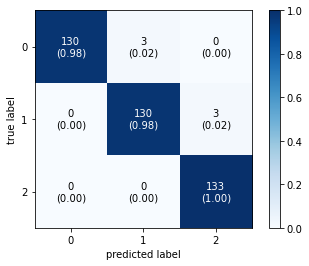

In [50]:
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True)

plt.savefig(os.path.join(char, 'cm.eps'))
plt.show()

In [51]:
from contextlib import redirect_stdout

readme_name_text = "readme.txt"
print("Please read the text file named " + readme_name_text + " for detailed information of the model.")

completeName_txt = os.path.join(char, readme_name_text) 

readme = open(completeName_txt, "w")

if len(os.listdir(TRAINING_DIR)) > 2:
    readme.write("This is a MULTICLASS CLASSIFICATION")
else:
    readme.write("This is a BINARY CLASSIFICATION")


readme.write("\n\n--HYPERPARAMETERS--\n")
readme.write("\nInitial Learning Rate = " + str(learning_rate))
readme.write("\nNo. of epochs = " + str(epoch))
readme.write("\nBatch Size = " + str(batch_size))


readme.write("\n\n--MODEL-PARAMETERS--")
readme.write("\nActivation Function = relu")
readme.write("\nDropout = " + str(int(dropout*100)) + "%")
readme.write("\nActivation function of the output layer = " + str(output_activation))
readme.write("\nCost function of the model = " + str(losses))
readme.write("\nOptimizer = " + str(optimizer) + "\n\n")


readme.write("Trained on a Custom Prebuilt Model\n")
readme.write("Number of Conv layer = " + str(conv_layer))
readme.write("\nFilter size = " + str(conv_size)+ "*" + str(conv_size) + "\n\n")
with redirect_stdout(readme):
    model.summary()


readme.write("\n\n--MODEL-CHARACTERISTICS--")
readme.write("\navg_acc = " + str(tr_acc))
readme.write("\n\navg_loss = " + str(tr_loss))
readme.write("\n\navg_val_acc = " + str(tr_val_acc))
readme.write("\n\navg_val_loss = " + str(tr_val_loss))


readme.write("\n\n--Classification Report--\n")
readme.write(classification_report)

readme.write("\nTrain Accuracy = " + str(cv_train) + " %")
readme.write("\nValidation Accuracy = " + str(cv_val) + " %")
readme.write("\nSensitivity = " + str(int(sensitivity*100)) + " %")
readme.write("\nSpecificity = " + str(int(specificity*100)) + " %")


readme.write("\n\nCreated using Self-Regulated Image Classifier using Convolution Neural Network")

readme.close()

Please read the text file named readme.txt for detailed information of the model.
